# Operator splitting 

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from nm_lib import nm_lib as nm
import importlib
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.interpolate import interp1d
importlib.reload(nm)

<module 'nm_lib.nm_lib' from '/home/astronih/Documents/nm_lib/nm_lib/nm_lib.py'>

## 1- OS precision

Solve the following Burgers' equation: 

$$\frac{\partial u}{\partial t} = - a \frac{\partial u}{\partial x} - b \frac{\partial u}{\partial x}   \tag{1}$$

following exersize [2b](https://github.com/AST-Course/AST5110/blob/main/ex_2b.ipynb). where $x[x_0, x_f]$ with $x_0 = −2.6$, $x_f = 2.6$, $a=-0.7$ and $b=-0.3$, periodic boundary conditions and with initial condition:

$$u(x,t=t_0) = \cos^2 \left(\frac{6 \pi x}{5} \right) / \cosh(5x^2)  \tag{2}$$

Solve the evolution for the following four different approaches: 

- 1 With additive OS.  

- 2 With Lie-Trotter OS. 

- 3 With Strang OS.

- 4 Without an operator splitting and single time-step method but add the to terms: 

$$\frac{\partial u}{\partial t} = - (a+b) \frac{\partial u}{\partial x}$$

for $nump=256$ and 100 steps.

_Suggestion_: use the Lax-method scheme for all cases with `deriv_cent`. Make sure the boundaries are properly selected.

Fill in the function `osp_LL_Add`, `osp_LL_Lie`, and `osp_LL_Strang`.

Start with $cfl\_cut = 0.4$ and increase up to $0.9$.  

Which OS schemes are stable? Which one is more diffusive? Why?

In [5]:

def u_init(x):
    """
    The initial function at t=t0

    Parameters
    ----------
    x   :   `array`
         Spatial axis
    
    Returns
    -------
    `array`
        The initial function at t=t0
    """
    ans = (np.cos(6*np.pi*x/5))**2 / np.cosh(5*x**2)
    return ans

def u(x, t, a=-1):
    """
    Analytical solution to the equation
    
    Requires
    --------
    u_init function

    Parameters
    -----------
    x   :   `array`
         Spatial axis
    t   :   `array`
         Time axis
    a : `float` or `array`
        Either constant, or array which multiply the right hand side of the Burger's eq.
        
    Returns
    -------
    `array`
        Analytical solution to burgers equations
    """
    X = (x - a*t)
    L = x[-1] - x[0]
    new_X = (X + L/2)%L - L/2
    ans = u_init(new_X)
    return ans
    
def spatial_domain(nump, x0=-2.6, xf=2.6):
    ans = np.arange(nump)/(nump - 1) * (xf - x0) + x0
    return ans

In [39]:
def synchronize_time(data, cfl_cut, num_frames):
    time_arrays = []
    data_arrays = []
    for key in data[cfl_cut]:
        time_arrays.append(data[cfl_cut][key]['tt'])
        data_arrays.append(data[cfl_cut][key]['unnt'])

        
    min_time = min([min(time_array) for time_array in time_arrays])
    max_time = max([max(time_array) for time_array in time_arrays])

    common_time = np.linspace(min_time, max_time, num=num_frames)

    sync_data = []
    for time, data in zip(time_arrays, data_arrays):
        interpolation = interp1d(time, data, kind='linear')(common_time)
        sync_data.append(interpolation)
    return common_time, sync_data

def compare(xx, time, data):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    Add, Lie, Strang, LH = data
    
    def init():
        axes.plot(xx, Add[:, 0], label='Add')
        axes.plot(xx, Lie[:, 0], label='Lie')
        axes.plot(xx, Strang[:, 0], label='Strang')
        axes.plot(xx, LH[:, 0], label='LH')
        axes.set_ylim(min(Add[:, 0]), max(Add[:, 0]))
        axes.set_ylim(-0.2, 1.2)
        axes.legend()

    def animate(i):

        axes.clear()
        axes.plot(xx, Add[:, i], label='Add')
        axes.plot(xx, Lie[:, i], label='Lie')
        axes.plot(xx, Strang[:, i], label='Strang')
        axes.plot(xx, LH[:, i], label='LH')
        axes.set_ylim(-0.2, 1.2)
        axes.legend()
        axes.set_title(f't={time[i]:.2f}')

    anim = FuncAnimation(fig, animate, interval=1, frames=len(time), init_func=init)
    return anim

def compare_same_time(xx, hh, nt, a, b, cfl_cut):
    cut = {}
    tt, unnt = nm.ops_Lax_LL_Add(xx, hh, nt, a, b, cfl_cut)
    cut["Add"] = {"tt":tt, "unnt":unnt}

    tt, unnt = nm.ops_Lax_LL_Lie(xx, hh, nt, a, b, cfl_cut)
    cut["Lie"] = {"tt":tt, "unnt":unnt}
    
    tt, unnt = nm.ops_Lax_LL_Strang(xx, hh, nt, a, b, cfl_cut)
    cut["Strang"] = {"tt":tt, "unnt":unnt}
    
    tt, unnt = nm.ops_Lax_LH_Strang(xx, hh, nt, a, b, cfl_cut)
    cut["Lax"] = {"tt":tt, "unnt":unnt}
    
    for key in cut:
        method = cut[key]
        interpolation_func = interp1d(method["tt"], method["unnt"], axis=1)
        t_interp = np.linspace(tt[0], tt[-1], num=len(xx))
        unnt_interp = interpolation_func(t_interp)
        cut[key]["interpolation"] = {'t_interp':t_interp, 'unnt_interp':unnt_interp}
        
    return cut
    
def plot_comparison(xx, data_dict, desired_time, cfl_cut):
    for key in data_dict:
        t = data_dict[key]['tt']
        unnt = data_dict[key]['unnt']


        # Find the index corresponding to the desired time
        t_index = np.abs(t - desired_time).argmin()

        # Get the initial unnt array
        initial_unnt = unnt[:, 0]

        # Plot the interpolated values at the desired time
        plt.plot(xx, unnt[:, t_index], label=f'{key}')
        plt.ylim(np.min(initial_unnt), np.max(initial_unnt))
        plt.xlim(xx[0], xx[-1])
        plt.xlabel('Spatial Axis')
        plt.ylabel('Interpolated unnt')
        plt.title(f'Interpolated unnt at t = {desired_time:.1f}, cfl_cut = {cfl_cut}')
        plt.grid(True)
    plt.legend()
    plt.show()
    
    
def plot_interpolated_data(data_dict, desired_time):
    # Extract data from the dictionary
    xx = data_dict['xx']
    for key in data_dict:
        t_interp = data_dict[key]['interpolation']['t_interp']
        unnt_interp = data_dict[key]['interpolation']['unnt_interp']
        unnt = data_dict[key]['unnt']


        # Find the index corresponding to the desired time
        t_index = np.abs(t_interp - desired_time).argmin()

        # Get the initial unnt array
        initial_unnt = unnt[:, 0]

        # Plot the interpolated values at the desired time
        plt.plot(xx, unnt_interp[t_index], label=f'{key}')
        plt.ylim(-np.max(initial_unnt), np.max(initial_unnt))
        plt.xlim(xx[0], xx[-1])
        plt.xlabel('Spatial Axis')
        plt.ylabel('Interpolated unnt')
        plt.title(f'Interpolated unnt at t = {desired_time:.1f}')
        plt.grid(True)
    plt.legend()
    plt.show()
        

In [7]:
nump = 512
xx = spatial_domain(nump)
nt = 20
t = np.linspace(0, 1)
U0 = u_init(xx)
a = -.7
b = -.3

[0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


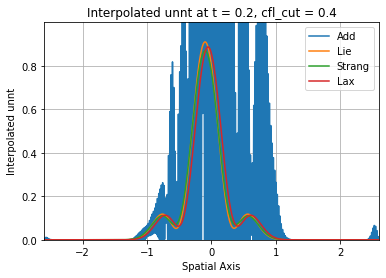

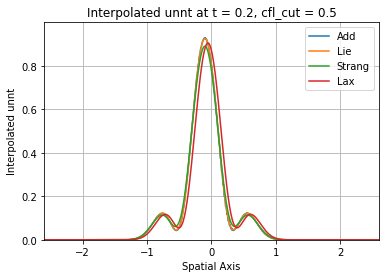

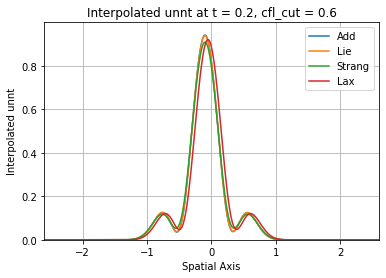

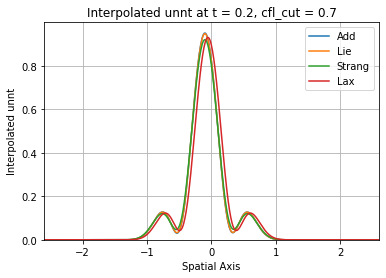

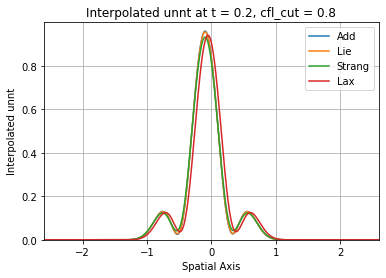

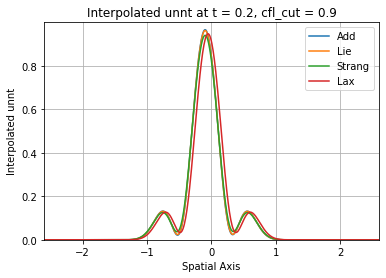

In [18]:
cfl_cuts = [i/10 for i in range(4, 10)]
data = {}
print(cfl_cuts)

for cfl_cut in cfl_cuts:
    data[cfl_cut] = compare_same_time(xx, U0, nt, a, b, cfl_cut)
    plot_comparison(xx, data[cfl_cut], 0.2, cfl_cut)

In [19]:
print(data[0.4]['Add'].keys())
tt, unnt, inter = data[0.4]['Add']

dict_keys(['tt', 'unnt', 'interpolation'])


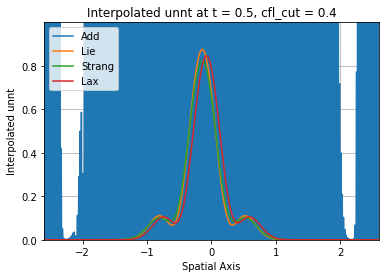

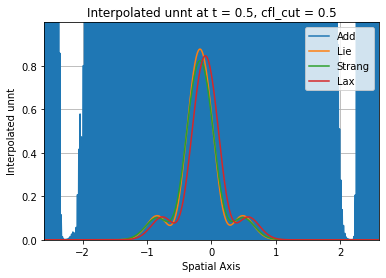

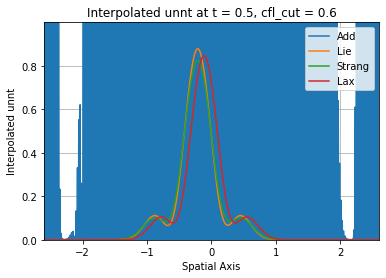

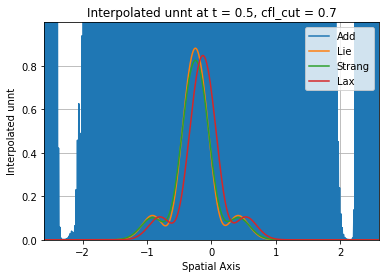

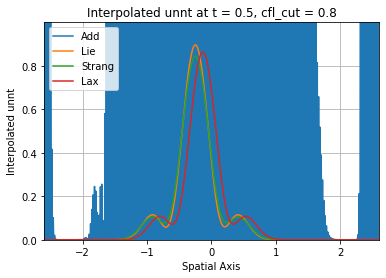

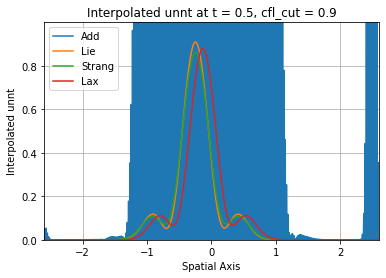

In [23]:
for cfl_cut in cfl_cuts:
    plot_comparison(xx, data[cfl_cut], 0.5, cfl_cut)


I have removed the `Add` method for now, when it doesn't seem to be stable at all. But the Lie and Strang methods are stable, but diffusive. Lie is the least diffusive. When we increase the `cfl_cut` there is not much difference between them, but a slight increase in diffusivness.

<span style="color:green"> JMS. </span>.

<span style="color:blue"> OK</span>.

<span style="color:red"> for a fare comparison, I suggest to compare at the same instance. you are comparing at different time</span>.

Now with comparison at the same time we observe that the *Add* method is the least diffusive, and *Strang* is the most.

dict_keys([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


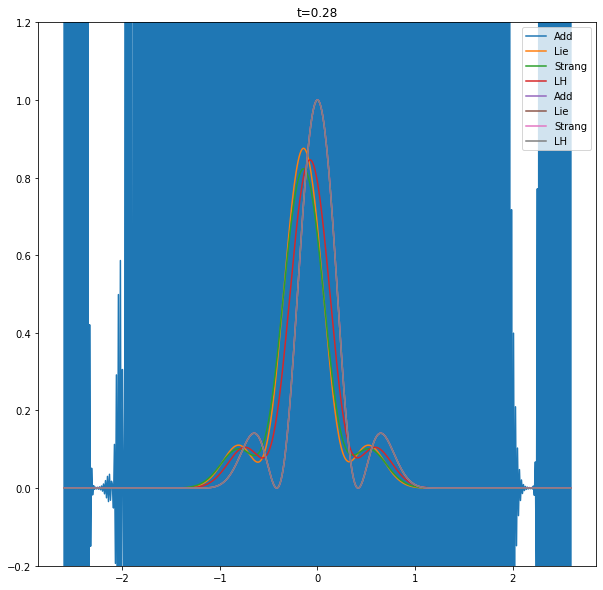

In [40]:
print(data.keys())
common_time, sync_data = synchronize_time(data, 0.4, nt)
anim = compare(xx, common_time, sync_data)
HTML(anim.to_jshtml())

## 2- When does it not work? 

Use OS-Strang from the previous exercise and try to apply a predictor-corrector explicit method. 
To facilitate this exercise, `nm_lib` already includes the predictor-corrector Hyman method, which is included Bifrost (`Hyman`). Fill in the function `osp_Lax_LH_Strang`. Use the same setup as the previous exercise but with $nump=512$, $500$ steps, and $cfl\_cut=0.8$. 

What do you notice? 

__Optional__: Apply the Hyman predictor-corrector explicit method to the Burgers equation and check if the following is true: 

$$u^{n+1} = F\, u^{n}\Delta t \approx G\, u^{n}\Delta t+H\, u^{n}\Delta t$$

In [11]:
nump = 512
nt = 50
cfl_cut = 0.8

In [12]:
xx = spatial_domain(nump)
t = np.linspace(0, 1, nt)
U0 = u_init(xx)
t_Strang, u_Strang = nm.ops_Lax_LH_Strang(xx, U0, nt, a=-0.7, b=-0.3, cfl_cut=cfl_cut)
data = [t_Strang, u_Strang]


In [13]:
def compare_2(data, key, label_1='Strang', label_2='Analytical'):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    t, u_1 = data
    
    U = u(np.repeat(xx[:, np.newaxis], nt, axis=1), 
        np.repeat(t[np.newaxis, :], nump, axis=0), a=-1)

    def init():
        axes.plot(xx, u_1[:, 0], label=label_1)
        axes.plot(xx, U[:, 0], label=label_2)
        axes.legend()

    def animate(i):

        axes.clear()
        axes.plot(xx, u_1[:, i], label=label_1)
        axes.plot(xx, U[:, i], label=label_2)
        axes.legend()
        axes.set_title(f"cfl_cut={key} t={t[i]:.2f}")

    anim = FuncAnimation(fig, animate, interval=1, frames=nt, init_func=init)
    return anim

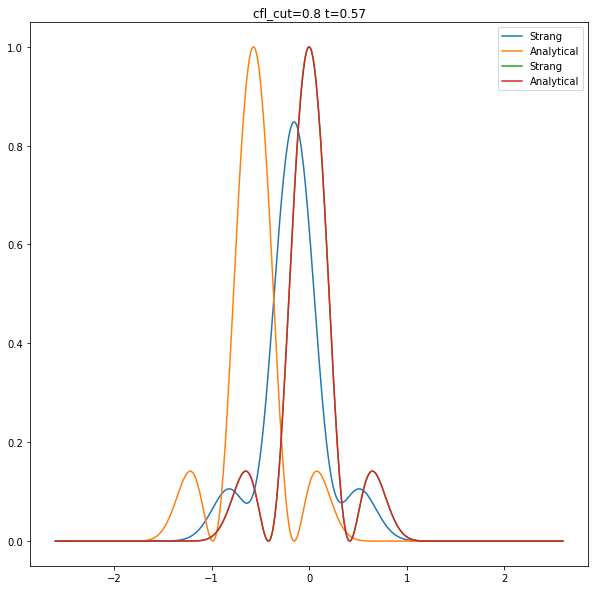

In [14]:
anim = compare_2(data, cfl_cut)
HTML(anim.to_jshtml())

#### Strang with `hyman` predictor breaks down almost imediatly

<span style="color:green"> JMS. </span>.

<span style="color:red"> The problem is not the crash, but something else. You have a couple of bugs in the implementation. Please, change the call to the hyman as follows. Let me know if there is something that is unclear in the changes. </span>.

        if(i == 0):
            v, u_old, dt_old = hyman(xx, v, dt, a=b, cfl_cut=cfl_cut, ddx=ddx, bnd_limits=bnd_limits)
        else:
            v, u_old, dt_old = hyman(xx, v, dt, a=b, fold=u_old, dtold=dt_old,
                              cfl_cut=cfl_cut, ddx=ddx, bnd_limits=bnd_limits)


The `hyman` call is fixed